Date: 06/24/2022

Create a mass distribution with a negative power law and a mass ratio distribution with a positive power law. 
Calculate SNR for two cases:

    1) fixed parameteres
    2) varying parameters (use bilby)

In [1]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import pylab
from bilby.core.prior import Uniform, Sine, Cosine, PowerLaw, Constraint
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import sigmasq
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import read as psd_read    

%matplotlib inline

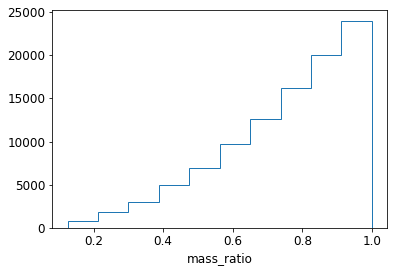

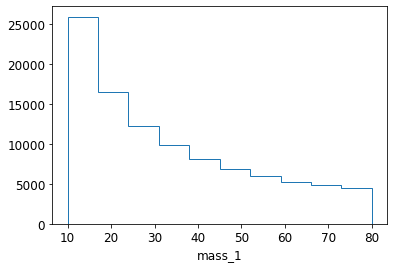

In [4]:
prior_case1 = dict(mass_ratio=PowerLaw(alpha=2, name='mass_ratio', minimum=0.125, maximum=1),
                   mass_1= PowerLaw(alpha=-1, name='mass_1', minimum=10, maximum=80))

# plotting distributions:
for key in prior_case1:
        pylab.xlabel(key)
        pylab.hist(prior_case1[key].sample(100000), histtype="step" )
        pylab.show()

In [29]:
def get_mass2(prior, n_samples):
    '''
    This function calculates mass_2 based on mass_ratio and mass_1
    '''
    mass_1 = prior['mass_1'].sample(n_samples)
    mass_2 = mass_1 * prior['mass_ratio'].sample(n_samples)
    return mass_1, mass_2
    
def calculate_snr(param_args):
    ifos=['H1', 'L1', 'V1'] 
    sample_rate=1024
    apx='IMRPhenomD'
    ra=2.2
    dec=-1.25
    pol=2.1 
    t_gps=120
    f_lower=10
    hp, hc=get_td_waveform(approximant=apx,
                            mass1=param_args['mass_1'],
                            mass2=param_args['mass_2'],
                            spin1z=param_args['spin_1z'],
                            spin1x=param_args['spin_1x'],
                            spin1y=param_args['spin_1y'],
                            spin2z=param_args['spin_2z'],
                            spin2x=param_args['spin_2x'],
                            spin2y=param_args['spin_2y'],
                            inclination=param_args['theta_jn'],
                            coa_phase=param_args['phase'],
                            distance=param_args['luminosity_distance'],
                            f_lower=f_lower,
                            delta_t=1.0/sample_rate)

    flow = 10.0
    delta_f = 1.0 / hp.duration 
    flen = int(sample_rate/delta_f)
    psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow) #optimize by calculating only once    
    gw = {'hp': hp, 'hc':hc, 'psd': psd}
    
    for ifo in ifos:
        det=Detector(ifo)
        fp, fc=det.antenna_pattern(ra, dec, pol, t_gps)
    
        s= fp * gw['hp'] + fc * gw['hc']
        snr = sigmasq(s,psd=gw['psd'], low_frequency_cutoff=10)
        if 'snr_sq' in gw:  
            gw['snr_sq'] += snr
        else:
            gw['snr_sq'] = snr
            
    return np.sqrt(gw['snr_sq'])

def distance_snr_drops(m1_distr, m2_distr, snr_thres = 8, step = 50):
    distance = 1
    max_distance = []
    for m1, m2 in zip(m1_distr, m2_distr):
        while True:
            param_args['mass_1']=m1
            param_args['mass_2']=m2
            param_args['luminosity_distance']=distance
            snr = calculate_snr(param_args)
            distance += step
    
            if snr < snr_thres:
                max_distance.append(distance)
                break
    return max_distance

Case 1: set parameteres

In [35]:
m1_distr, m2_distr = get_mass2(prior_case1, 1000)
snrs_list = []
param_args = dict(spin_1z=0.1,
                  spin_1x=0,
                  spin_1y=0,
                  spin_2z=0.2,
                  spin_2x=0,
                  spin_2y=0,
                  theta_jn=3.14/2,
                  phase=0)
param_args['luminosity_distance']=1
for m1, m2 in zip(m1_distr, m2_distr):
    param_args['mass_1']=m1
    param_args['mass_2']=m2
    snrs_list.append(calculate_snr(param_args))

Text(0, 0.5, 'mass 2')

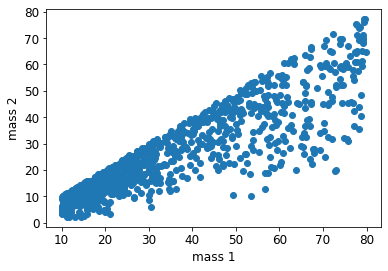

In [44]:
pylab.scatter(m1_distr, m2_distr)
pylab.xlabel('mass 1')
pylab.ylabel('mass 2')

Text(0, 0.5, 'bins')

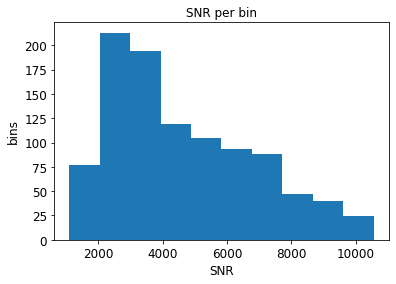

In [36]:
# Graph with the SNR generated for fixed parameters - for the above m1 and m2 distribution
pylab.hist(snrs_list)
pylab.title('SNR per bin')
pylab.xlabel('SNR')
pylab.ylabel('bins')

Text(0, 0.5, 'SNR')

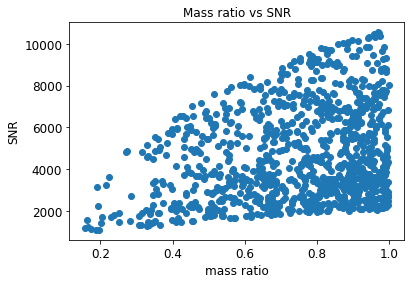

In [45]:
pylab.scatter(m2_distr/m1_distr, snrs_list)
pylab.title('Mass ratio vs SNR')
pylab.xlabel('mass ratio')
pylab.ylabel('SNR')

Text(0, 0.5, 'distance')

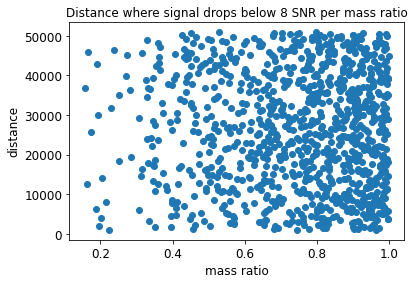

In [38]:
#calculate the distance it drops below 8 SNR
max_distance_c1 = distance_snr_drops(m1_distr, m2_distr)
pylab.title('Distance where signal drops below 8 SNR per mass ratio')
pylab.scatter(m2_distr/m1_distr, max_distance_c1)
pylab.xlabel('mass ratio')
pylab.ylabel('distance')